# TalkingData Preview

The evaluation metric used here is ROC-AUC, which means:
* This is a binary-classificaiton problem, and our goal is to classify our users into "fraudulent" and "non-fraudulent".
* Unlike the metric of LogLoss, the ROC-AUC depends on how well you separate the two classes. As a result, the model's probability results won't affect the score. 

### Content
0. [Data Import](#data_import)
1. [Data Overview & EDA](#data_overview)
2. [Data Engineering](#data_engineering)
3. Modeling & Prediction

## Data Import <a id="data_import"></a>

In [1]:
cd "/Users/lli2/Git/kaggle/TalkingData_AdTracking"

/Users/lli2/Git/kaggle/TalkingData_AdTracking


In [47]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os 

pal = sns.color_palette()

%matplotlib inline

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/Users/lli2/Git/kaggle_data'
for f in os.listdir(data_dir):
    if 'zip' not in f:
        print(f.ljust(20) + str(round(os.path.getsize(data_dir + '/' + f)/1000000, 2)) + " MB")

test.csv            863.27 MB
train.csv           7537.65 MB


## Data Overview & EDA <a id="data_overview"></a>

In [288]:
df_train = pd.read_csv(data_dir + '/train.csv', nrows=10000000)
#df_test = pd.read_csv(data_dir + '/test.csv', nrows=1000000)

In [289]:
common_names = df_train.columns.intersection(df_test.columns).values

In [291]:
# df_train.describe()

In [292]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [293]:
# df_test = df_test[common_names]
# df_test.head()

#### Looking at the columns
* ip: ip address of click
* app: app id for marketing
* device: device type id of user mobile phone 
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded

#### Data Type Transformation

DateTime

In [352]:
dat_var = ['click_time', 'attributed_time']
print(dat_var)
for dv in dat_var:
    df_train[dv] = pd.to_datetime(df_train[dv])

['click_time', 'attributed_time']


Categorical

In [353]:
cat_var = set(df_train.columns.values) - set(dat_var)
print(cat_var)
for cv in cat_var:
    df_train[cv] = df_train[cv].astype('category')

{'channel', 'is_attributed', 'os', 'app', 'ip', 'device'}


Check the data type of each column

In [356]:
df_train.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed            category
dtype: object

### Data Visualization - General

#### Unique number of records in each field

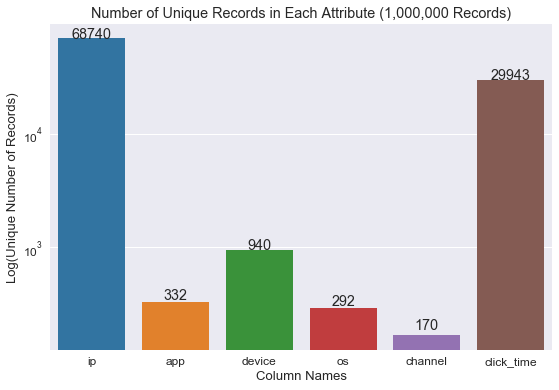

In [294]:
unique_count = [len(df_train[col].unique()) for col in common_names]

plt.figure(figsize=(9,6))
sns.set(font_scale=1.2)
ax = sns.barplot(x=common_names, y=unique_count, palette=pal, log=True)
ax.set(xlabel="Column Names", 
       ylabel="Log(Unique Number of Records)", 
       title="Number of Unique Records in Each Attribute (1,000,000 Records)")

for p, uniq in zip(ax.patches, unique_count):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 20,
            uniq,
            ha="center")

plt.show();

### Data Visualization - Individual Variable

#### Variable - IP

68740
Variable 'ip': | Unique values: 68740 | Highest Frequenct: 51711 | Lowest Frequency: 1
Frequency>=100: 34.67% | Frequency>=1000: 1.68% | Frequency>=10000: 0.04%
Note: More than 50% of IPs showed up less than 10 times.


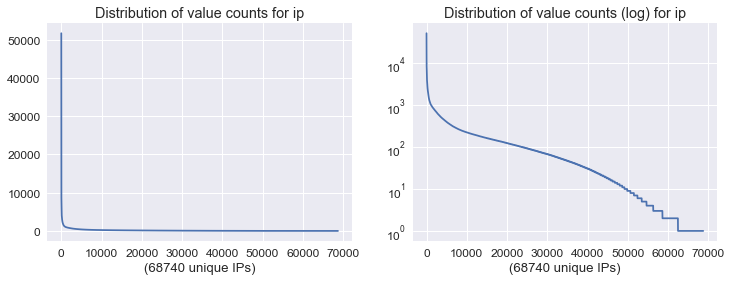

In [310]:
var_viz = 'ip'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1] # the frequency of each unique IP
print(len(sorted_count)) # 68740 unique IPs


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sorted_count)
#ax.set_yscale('log')
ax.set(title="Distribution of value counts for {}".format(var_viz),
       xlabel="({unique_cnt} unique {var}s)".format(unique_cnt=len(sorted_count), var=var_viz.upper()));

ax = fig.add_subplot(1, 2, 2)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Distribution of value counts (log) for {}".format(var_viz),
       xlabel="({unique_cnt} unique {var}s)".format(unique_cnt=len(sorted_count), var=var_viz.upper()));


print("Variable '{a}': | Unique values: {b} | Highest Frequenct: {c} | Lowest Frequency: {d}".format(a=var_viz, 
                                                                                                     b=len(sorted_count), 
                                                                                                     c=sorted_count[0], 
                                                                                                     d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=1000: {b}% | Frequency>=10000: {c}%".format(a=str(round((sorted_count>=100).mean()*100, 2)), 
                                                                                  b=str(round((sorted_count>=1000).mean()*100, 2)), 
                                                                                  c=str(round((sorted_count>=10000).mean()*100, 2))))

print("Note: More than 50% of IPs showed up less than 10 times.")


For every 50 Frequency number, how many records occurance time is equal to it. For example, how many unique IPs have an occurance of 1-5 times.

Note: 
Rare IP will show up more than 2000 times and even rare to show up more than 6000 times. 
They could be some fraudulent or outliers.


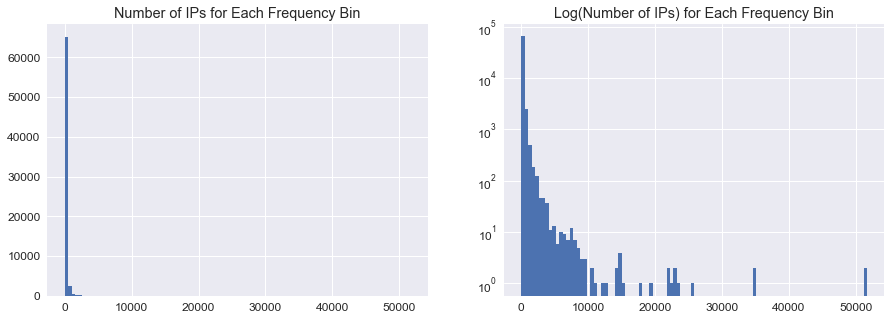

In [297]:
var_viz = 'ip'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1] # the frequency of each unique IP

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.hist(sorted_count, bins=100) # Counts of Unique IP for a frequency range
ax.set(title="Number of {}s for Each Frequency Bin".format(var_viz.upper()));

ax = fig.add_subplot(1, 2, 2)
plt.hist(sorted_count, bins=100) # Counts of Unique IP for a frequency range
ax.set_yscale('log', nonposy='clip') # nonposy: log(1) = 0 --> clipped to a very small positive number
ax.set(title="Log(Number of {}s) for Each Frequency Bin".format(var_viz.upper()));


print("Note: \nRare IP will show up more than 2000 times and even rare to show up more than 6000 times. \nThey could be some fraudulent or outliers.")




#### Variable - APP

332
Variable app | Unique Value: 332 | Highest Frequency: 1291185 | Lowest Frequency: 1
Frequency>=100: 36.45% | Frequency>=10000: 8.43% | Frequency>=100000: 5.72%
Note: The distribution of frequencies of apps makes sense.


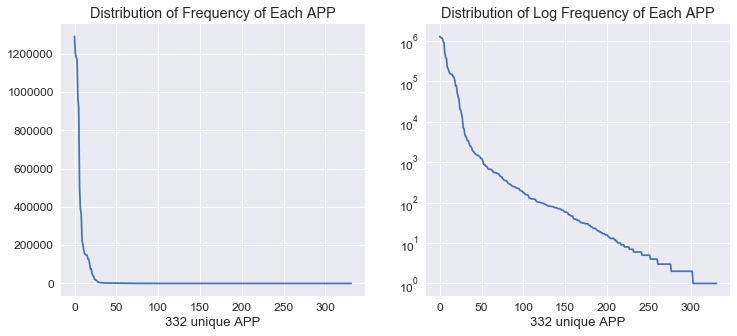

In [309]:
var_viz = 'app'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 332 unique APPs

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set(title="Distribution of Frequency of Each APP", 
       xlabel="{} unique {}".format(len(sorted_count), var_viz.upper()));


ax = fig.add_subplot(122)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Distribution of Log Frequency of Each APP", 
       xlabel="{} unique {}".format(len(sorted_count), var_viz.upper()));


print("Variable {a} | Unique Value: {b} | Highest Frequency: {c} | Lowest Frequency: {d}".format(a=var_viz,
                                                                                                 b=len(sorted_count),
                                                                                                 c=sorted_count[0],
                                                                                                 d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=10000: {b}% | Frequency>=100000: {c}%".format(a=round((sorted_count>=100).mean()*100,2),
                                                                                    b=round((sorted_count>=10000).mean()*100,2),
                                                                                    c=round((sorted_count>=100000).mean()*100,2)))

print("Note: The distribution of frequencies of apps makes sense.")

Note: It seems APP is a 'winner-takes-all' game. 
The majority of APPs only have 1 frequency and some could get frequency larger than 80000.


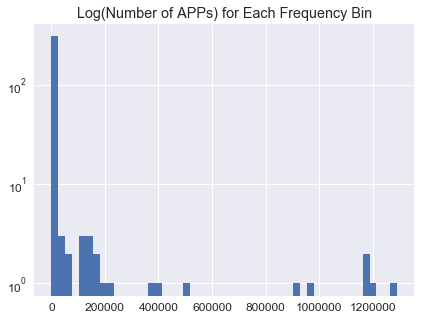

In [302]:
var_viz = 'app'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig=plt.figure(figsize=(15, 5))
ax=fig.add_subplot(121)
plt.hist(sorted_count, bins=50)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Log(Number of {}s) for Each Frequency Bin".format(var_viz.upper()),
       )
;


print("Note: It seems APP is a 'winner-takes-all' game. \nThe majority of APPs only have 1 frequency and some could get frequency larger than 80000.")



#### Variable - Device

940
Variable: 'device' | Unique Values: 940 | Highest Frequency: 9381146 | Lowest Frequency: 1
Frequency>=100: 2.34% | Frequency>=1000: 0.53% | Frequency>=10000: 0.43%
Note: Half of the devices have only 1 record.


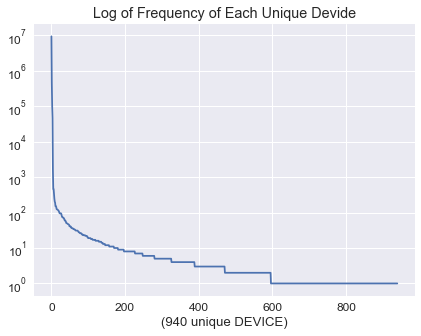

In [308]:
var_viz = 'device'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 940 unique devices

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title = "Log of Frequency of Each Unique Devide",
       xlabel = "({} unique {})".format(len(sorted_count), var_viz.upper()));

print("Variable: '{a}' | Unique Values: {b} | Highest Frequency: {c} | Lowest Frequency: {d}".format(a=var_viz,
                                                                                                     b=len(sorted_count),
                                                                                                     c=sorted_count[0],
                                                                                                     d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=1000: {b}% | Frequency>=10000: {c}%".format(a=round((sorted_count>=100).mean()*100, 2),
                                                                               b=round((sorted_count>=1000).mean()*100, 2),
                                                                               c=round((sorted_count>=10000).mean()*100, 2)))

print("Note: Half of the devices have only 1 record.")

Note: Only few device have a frequency larger than 10. 


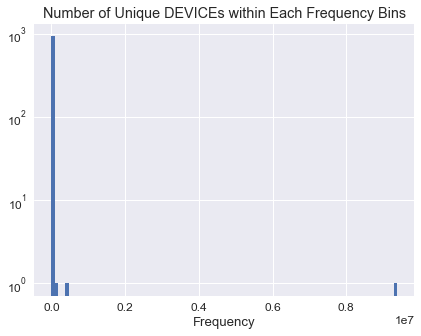

In [305]:
var_viz = 'device'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Number of Unique {}s within Each Frequency Bins".format(var_viz.upper()),
       xlabel="Frequency");

print("Note: Only few device have a frequency larger than 10. ")

#### Variable - OS

292


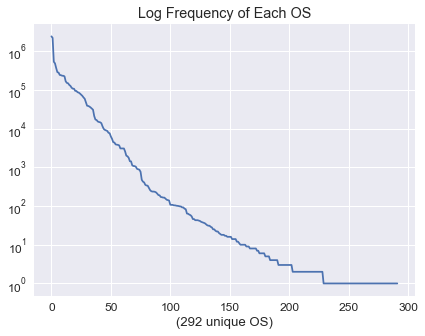

In [312]:
var_viz = 'os'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 292 unique OS

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Log Frequency of Each OS",
       xlabel="({} unique {})".format(len(sorted_count), var_viz.upper()));

Note: It's possible that the 'rare' OSs are associated with those rare devices or IPs.


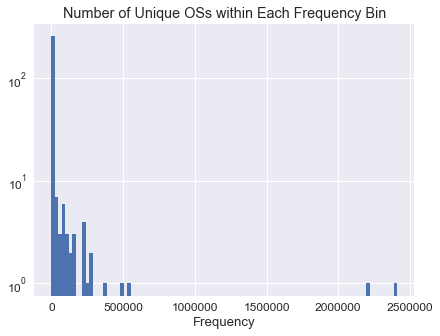

In [315]:
var_viz = 'os'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Number of Unique {}s within Each Frequency Bin".format(var_viz.upper()),
       xlabel="Frequency");


print("Note: It's possible that the 'rare' OSs are associated with those rare devices or IPs.")

#### Variable - Channel

170



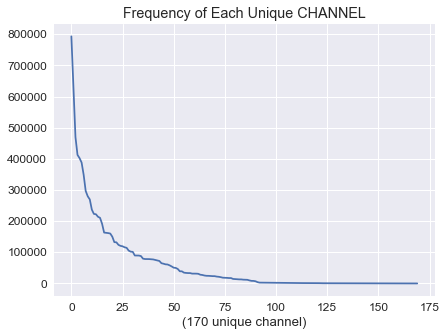

In [311]:
var_viz = 'channel'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 170 unique channels

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set(title="Frequency of Each Unique {}".format(var_viz.upper()),
       xlabel="({} unique {})".format(len(sorted_count), var_viz));

print("")


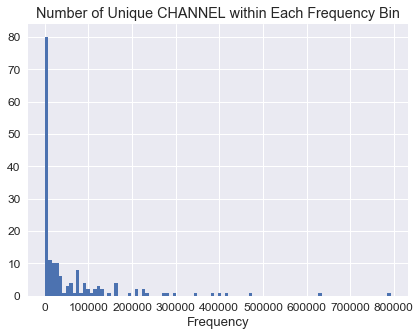

In [316]:
var_viz = 'channel'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set(title="Number of Unique {} within Each Frequency Bin".format(var_viz.upper()),
       xlabel="Frequency".format(len(sorted_count), var_viz));

print("")

#### Variable - Click Time

In [272]:
click_date = pd.to_datetime(df_train['click_time']).dt.date
click_hour = pd.to_datetime(df_train['click_time']).dt.hour
click_dow = 

click_date.value_counts().as_matrix()


array([1000000])

In [287]:
click_hour.value_counts()

16    999517
15       435
14        48
Name: click_time, dtype: int64

### Data Visualization - VS. Dependent Variable

## Data Engineering <a id="data_engineering"></a>

###### Missing data

###### IP Frequency Group